# Parameter sweep for LBI predictor

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

plt.style.use("huddlej")

In [2]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [3]:
sys.path.insert(0, "../src")

In [21]:
from fit_model import ExponentialGrowthModel
from forecast.metrics import mean_absolute_error, sum_of_squared_errors

## Load data

In [5]:
last_timepoint = pd.to_datetime("2011-10-01")

In [6]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/standardized_tip_attributes.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [7]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "cTiterSub", "lbi", "ep", "ne", "frequency"]].copy()

In [8]:
X = X[X["timepoint"] <= last_timepoint]

In [9]:
X.head()

,strain,clade_membership,timepoint,cTiterSub,lbi,ep,ne,frequency
0,A/Argentina/7646/2009,"HA1:50E,HA1:140I,HA1:173Q,HA1:193F,HA1:225N,HA...",2009-10-01,-2.440784,-1.695891,-2.466446,0.042910,0.000503
1,A/Australia/2/2009,"HA1:50E,HA1:62K,HA1:140I,HA1:144K,HA1:158N,HA1...",2009-10-01,0.257702,0.417716,0.597140,0.042910,0.000086
2,A/Australia/55/2009,"HA1:50E,HA1:62K,HA1:140I,HA1:144K,HA1:158N,HA1...",2009-10-01,0.257702,0.237732,0.086542,-0.800981,0.000246
3,A/Bangladesh/7772/2009,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",2009-10-01,0.257702,0.955962,-0.424056,0.042910,0.000002
4,A/Brazil/1814/2009,"HA1:50E,HA1:140I,HA1:173Q,HA1:193F,HA1:225N,HA...",2009-10-01,-2.440784,-1.490310,-1.955849,1.730692,0.000001


In [10]:
X.shape

(312, 8)

In [11]:
# Load final clade tip frequencies.
final_clade_frequencies = pd.read_csv(
    "../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/final_clade_frequencies.tsv",
    sep="\t",
    parse_dates=["initial_timepoint", "final_timepoint"]
)

In [12]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2009-10-01,"HA1:50E,HA1:140I,HA1:173Q,HA1:193F,HA1:225N,HA...",2010-10-01,NaN,0.000000
1,2009-10-01,"HA1:50E,HA1:62K,HA1:140I,HA1:144K,HA1:158N,HA1...",2010-10-01,NaN,0.000000
2,2009-10-01,"HA1:50E,HA1:62K,HA1:140I,HA1:144K,HA1:158N,HA1...",2010-10-01,A/Brazil/610/2010,0.000002
3,2009-10-01,"HA1:50E,HA1:62K,HA1:140I,HA1:144K,HA1:158N,HA1...",2010-10-01,A/Brazil/791/2010,0.000102
4,2009-10-01,"HA1:50E,HA1:62K,HA1:140I,HA1:144K,HA1:158N,HA1...",2010-10-01,A/Ghana/FS-10-3811/2010,0.000274


In [13]:
y = final_clade_frequencies.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

In [14]:
y = y.rename(
    columns={"initial_timepoint": "timepoint"}
)

In [15]:
y = y[y["timepoint"] <= last_timepoint]

In [16]:
y.head()

,timepoint,clade_membership,frequency
0,2009-10-01,"HA1:3F,HA1:50E,HA1:140I,HA1:193F,HA1:225N,HA2:...",0.000000
1,2009-10-01,"HA1:50E,HA1:140I,HA1:158N,HA1:173Q,HA1:189K,HA...",0.899806
2,2009-10-01,"HA1:50E,HA1:140I,HA1:158R,HA1:173Q,HA1:193F,HA...",0.000000
3,2009-10-01,"HA1:50E,HA1:140I,HA1:173Q,HA1:193F,HA1:225N,HA...",0.000000
4,2009-10-01,"HA1:50E,HA1:62K,HA1:140I,HA1:144K,HA1:158N,HA1...",0.000000


## Inspect LBI model

In [17]:
predictors = ["lbi"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

Define the range of possible coefficient values to explore.

In [18]:
coefficients = np.linspace(-2, 2, 20)

Calculate error for an LBI model across all coefficients.

In [19]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

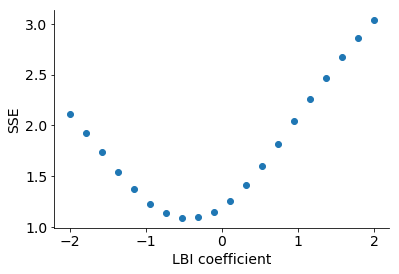

In [20]:
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

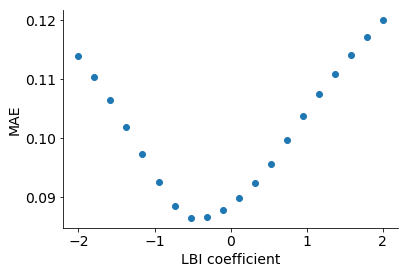

In [23]:
predictors = ["lbi"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("MAE")

## Inspect cTiterSub model

In [24]:
predictors = ["cTiterSub"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [25]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

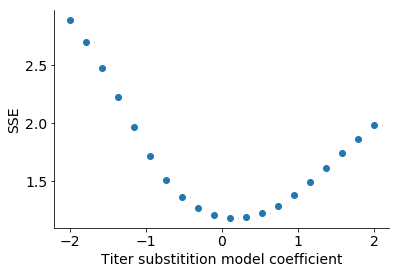

In [26]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer substitition model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

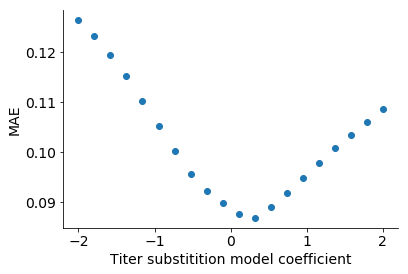

In [27]:
predictors = ["cTiterSub"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer substitition model coefficient")
plt.ylabel("MAE")

## Inspect epitope count model

In [28]:
predictors = ["ep"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [29]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

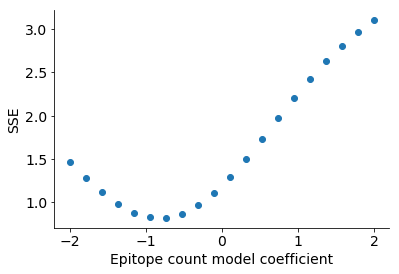

In [30]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

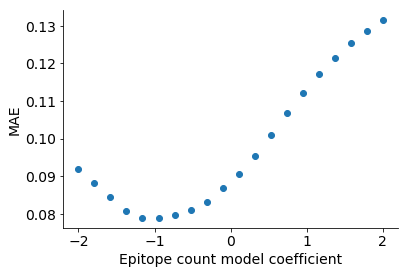

In [31]:
predictors = ["ep"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("MAE")

## Inspect two-parameter models

In [32]:
predictors = ["lbi", "cTiterSub"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [33]:
len(coefficients)

20

In [34]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

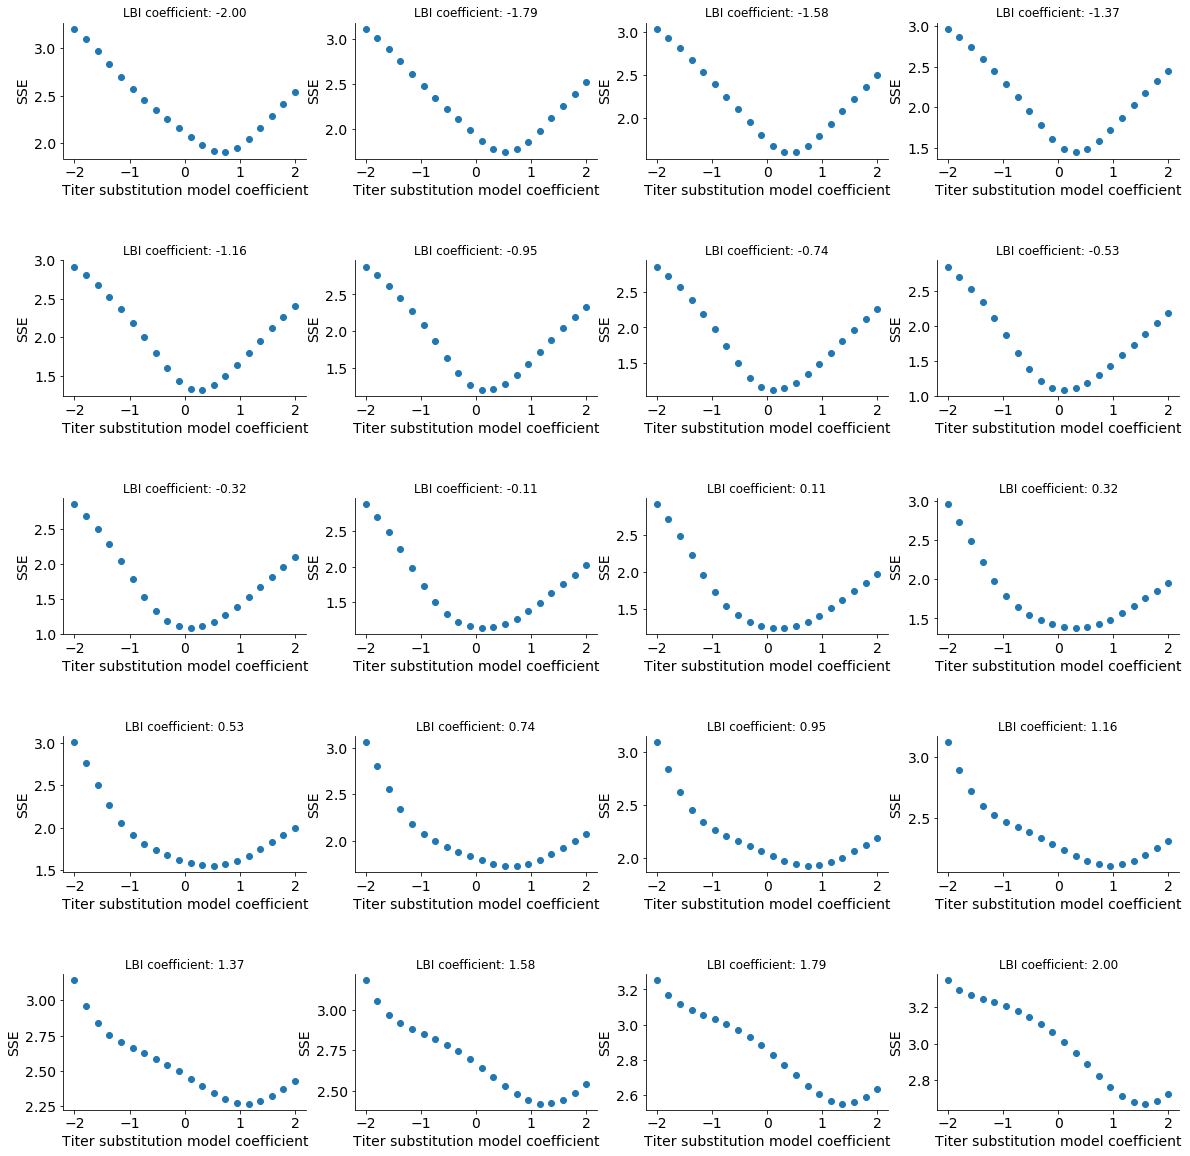

In [35]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75})

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("SSE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [36]:
predictors = ["lbi", "cTiterSub"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

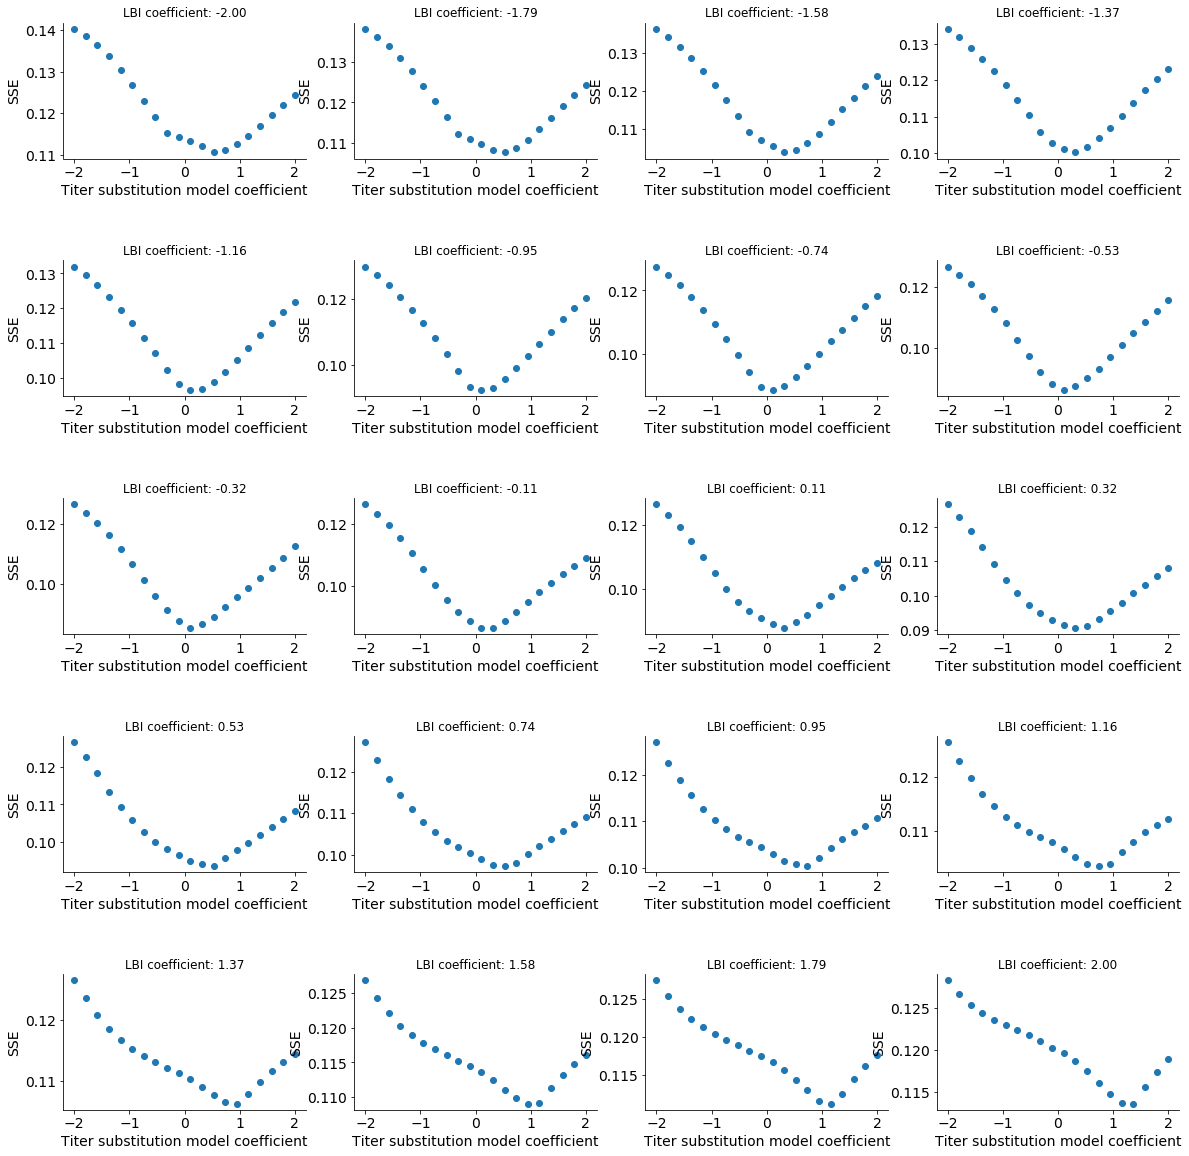

In [37]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75})

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("SSE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)